In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
df = pd.read_csv('clean_amazon_sales_report.csv')

# Feature engineering
df['order_date'] = pd.to_datetime(df['Date'])
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.dayofweek


# Fill missing values for numerical columns with median
for col in df.select_dtypes(include=[np.number]):
    df.fillna({col:df[col].median()}, inplace=True)

# Fill missing values for categorical columns with mode
for col in df.select_dtypes(include=[object]):
    df.fillna({col:df[col].mode()[0]}, inplace=True)

# Define features and target
features = df[['order_month','order_day','Fulfilment','Sales Channel','ship-service-level','Size','Amount','ship-postal-code','B2B','fulfilled-by','ASIN']] 
target = df['Status']

# Identify categorical and numerical features
categorical_features = features.select_dtypes(include=['object']).columns
numerical_features = features.select_dtypes(include=[np.number]).columns



C:\Users\PC\AppData\Local\Temp\ipykernel_27520\3322542235.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clean_amazon_sales_report.csv')
C:\Users\PC\AppData\Local\Temp\ipykernel_27520\3322542235.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna({col:df[col].mode()[0]}, inplace=True)


In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [9]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [ 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}



# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['order_month', 'order_day', 'Amount', 'ship-postal-code'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['Fulfilment', 'Sales Channel', 'ship-service-level', 'Size',
       'fulfilled-by', 'ASIN'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, 30],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [5]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))



Accuracy: 0.83
Classification Report:


c:\Users\Karim\Desktop\slash_model\slash\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                               precision    recall  f1-score   support

                    Cancelled       0.00      0.00      0.00      3631
                      Pending       0.00      0.00      0.00       132
Pending - Waiting for Pick Up       0.00      0.00      0.00        63
                      Shipped       0.87      1.00      0.93     15541
            Shipped - Damaged       0.00      0.00      0.00         1
 Shipped - Delivered to Buyer       0.73      1.00      0.85      5788
   Shipped - Out for Delivery       0.00      0.00      0.00         4
          Shipped - Picked Up       0.00      0.00      0.00       201
  Shipped - Rejected by Buyer       0.00      0.00      0.00         2
 Shipped - Returned to Seller       0.00      0.00      0.00       401
Shipped - Returning to Seller       0.00      0.00      0.00        30
                     Shipping       0.00      0.00      0.00         1

                     accuracy                           0.83     25795
    

c:\Users\Karim\Desktop\slash_model\slash\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Karim\Desktop\slash_model\slash\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


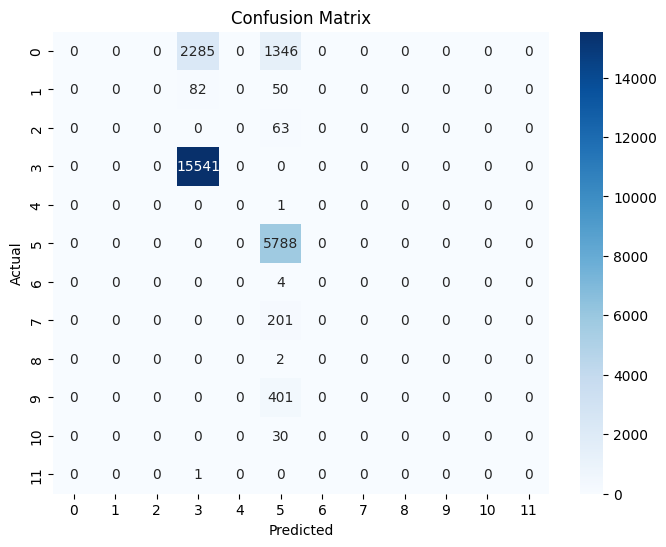

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [17]:
import joblib

# Save the model
model_filename = 'random_forest_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")


Model saved to random_forest_model.pkl
